# TFM in R: Errors with propagate

1. Data A: BPT, Metallicities and SFRs
2. Errors BPT Diagram
3. Errors SF Galaxies of the BPT Diagram
4. Errors Metallicities
5. Errors SFRs
6. Data B: Fils, Tendrils and Voids
7. Errors Metallicities: Fils, Tendrils and Voids
 

**Aviso:** Hemos puesto una barra de error para ver cuanto tarda el propagate. No osbtante, no es muy útil utilizarle porque hace que los bucles tarden mucho más al tener que imprimir el progreso. Por tanto, es recomendable borrarla una vez se quiera correr el bucle de forma definitiva. 

In [1]:
# Progress bar
progress_bar <- function(iteration, total, length = 50) {
  percent <- round((iteration / total) * 100, 1)
  progress <- round((iteration / total) * length)
  bar <- paste0(rep("=", progress), rep(" ", length - progress))
  cat("\r[", bar, "] ", percent, "%", sep = "")
  flush.console()
}

## 1. Data  A: BPT, Metallicities and SFRs

In [3]:
# Packages
library('propagate') #paquete principal para propagar errores
library('MASS')
library('tmvtnorm')
library('mvtnorm')
library('Matrix')
library('stats4')
library('gmm')
library('sandwich')
library('Rcpp')
library('ff')
library('bit')
library('repr') #reajustar tamaño plots
library('minpack.lm')
library('ff')

# Options 
options(repr.plot.width=14, repr.plot.height=12)
options(mc.cores = parallel::detectCores())

#GALAXIAS DIAGRAMA BPT
data_BPT=read.table("./DataFrames_and_Tables/data_frame_BPT.txt") #datos
names(data_BPT)=c("Ha","Ha_Error","Hb","Hb_Error","NII","NII_Error","OIII","OIII_Error") #nombres datos bpt diagram

Ha=data_BPT$Ha #Ha
Ha_Error=data_BPT$Ha_Error #error Ha

Hb=data_BPT$Hb #Hb
Hb_Error=data_BPT$Hb_Error #error Hb

NII=data_BPT$NII #NII
NII_Error=data_BPT$NII_Error #error NII

OIII=data_BPT$OIII #OIII
OIII_Error=data_BPT$OIII_Error #error OIII

#GALAXIAS SF
data_SF=read.table("./DataFrames_and_Tables/data_frame_SF.txt") #datos
names(data_SF)=c("Ha","Ha_Error","Hb","Hb_Error","NII","NII_Error","OIII","OIII_Error","EW_Ha","M_r_petro","z") #nombres datos bpt diagram

Ha_SF=data_SF$Ha #Ha_SF
Ha_SF_Error=data_SF$Ha_Error #error Ha_SF

Hb_SF=data_SF$Hb #Hb_SF
Hb_SF_Error=data_SF$Hb_Error #error Hb_SF

NII_SF=data_SF$NII #NII_SF
NII_SF_Error=data_SF$NII_Error #error NII_SF

OIII_SF=data_SF$OIII #OIII_SF
OIII_SF_Error=data_SF$OIII_Error #error OIII_SF

EW_Ha_SF=data_SF$EW_Ha #EW_SF

M_r_petro_SF=data_SF$M_r_petro #magnitud_r_petrosian_SF
z_SF=data_SF$z #rdshift_SF

#GALAXIAS SF (con flujos observados, es decir, no corregidos -> necesarios para la ecuación para calcular SFR_{Hopkins}
data_SF2=read.table("./DataFrames_and_Tables/data_frame_SF_v2.txt", header = TRUE, sep = "\t") #datos

In [4]:
#Visualización data
data_BPT[0:5,0:8]
length(Ha) #longitud de las galaxias del diagrama BPT

data_SF[0:5,0:11]
length(Ha_SF) #longitud de las galaxias SF

data_SF2[0:5,0:9]
length(data_SF2$EW_Ha_SF) # longitud de las galaxias SF (sólo flujos observados en los datos, no corregidos)

,Ha,Ha_Error,Hb,Hb_Error,NII,NII_Error,OIII,OIII_Error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,294.40710,14.24592,137.71290,12.95788,157.14337,12.90902,187.36380,12.56536
2,97.34119,2649.81300,34.35812,1309.14400,32.47367,851.63920,42.95794,1768.81700
3,271.74870,1993.67400,94.88628,779.89140,101.08922,770.83690,133.01280,1183.50900
4,447.37000,19.63235,156.34140,18.93398,198.30247,26.25043,248.17410,20.87182
5,65.02176,970.03250,22.78687,613.29320,36.56406,525.43580,40.65727,888.19070


[1] 17368

,Ha,Ha_Error,Hb,Hb_Error,NII,NII_Error,OIII,OIII_Error,EW_Ha,M_r_petro,z
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,97.34119,2649.81300,34.35812,1309.14400,32.47367,851.639200,42.95794,1768.817000,9.057851e+13,-18.48071,0.090524
2,1135.77940,52.31658,396.66700,39.01183,122.26810,29.229830,376.23910,49.670660,2.593569e+01,-20.72695,0.105420
3,368.76693,13.63515,128.89610,15.18527,56.46208,23.833970,345.04029,15.796330,9.276756e+01,-20.56854,0.193308
4,160.16152,12.87582,55.96878,10.15529,24.27284,6.764302,86.30330,8.765275,3.487243e+01,-20.55494,0.208377
5,519.95175,11.60386,181.48080,14.45722,95.25224,9.480859,257.99459,13.578530,3.081700e+01,-20.64930,0.178436


[1] 13689

,EW_Ha_SF,EW_Ha_SF_Error,M_r_SF,Ha_obs_SF,Ha_obs_SF_Error,Hb_obs_SF,Hb_obs_SF_Error,z_SF,logmstar_SF
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9.057851e+13,1.089799e+31,-18.48071,97.34119,2649.81350,34.35812,1309.14440,0.09163417,9.006855
2,2.593569e+01,1.644405e+00,-20.72695,559.72015,52.31658,144.85364,39.01183,0.10659121,9.747728
3,9.276756e+01,NA,-20.56854,300.16248,13.63515,96.15655,15.18527,0.19481833,9.503660
4,3.487242e+01,NA,-20.55494,113.18153,12.87583,34.14254,10.15529,0.20957248,9.805308
5,3.081700e+01,2.163126e+00,-20.64930,176.51780,11.60386,38.98763,14.45722,0.17959835,10.018616


[1] 13689

## 2. Errors BPT Diagram

Calculamos los errores para las galaxias del BPT Diagramas (SF, AGN and Composites)

#### x axis error BPT Diagram

In [ ]:
#ERROR PROPAGATE MONTE-CARLO: EJE X DIAGRAMA BPT=0.041994829846394

ErrorMet_MC=vector("numeric")

EXPR1=expression(log10(NII/Ha))

for (i in 1:100){ #length(data_BPT$Ha)
 
    Ha=c(data_BPT$Ha[i],data_BPT$Ha_Error[i])
    NII=c(data_BPT$NII[i],data_BPT$NII_Error[i])

    DF1=makeDat(EXPR1)
 
    RES2=propagate(expr=EXPR1,data=DF1,type="stat",second.order=FALSE,nsim=10000,do.sim=TRUE)
    ErrorMet_MC[i]=ifelse(RES2$sim[2]>0,RES2$sim[2],-9999.0)

    #progress_bar(i,100)
    #Sys.sleep(0.1)
}

hist(ErrorMet_MC[ErrorMet_MC>0],xlim=c(0,0.8),breaks='fd',col="blue",main ="x axis error BPT Diagram")

median(ErrorMet_MC[ErrorMet_MC>0])

#### y axis error BPT Diagram

In [ ]:
#ERROR PROPAGATE MONTE-CARLO: EJE Y DIAGRAMA BPT=0.0610989829348798

ErrorMet_MC=vector("numeric")

EXPR1=expression(log10(OIII/Hb))

for (i in 1:100){ #length(data_BPT$Ha)
 
    Hb=c(data_BPT$Hb[i],data_BPT$Hb_Error[i])
    OIII=c(data_BPT$OIII[i],data_BPT$OIII_Error[i])

    DF1=makeDat(EXPR1)
 
    RES2=propagate(expr=EXPR1,data=DF1,type="stat",second.order=FALSE,nsim=10000,do.sim=TRUE)
    ErrorMet_MC[i]=ifelse(RES2$sim[2]>0,RES2$sim[2],-9999.0)

    #progress_bar(i,100)
    #Sys.sleep(0.1)
}

hist(ErrorMet_MC[ErrorMet_MC>0],xlim=c(0,0.8),breaks='fd',col="blue",main ="y axis error BPT Diagram")

median(ErrorMet_MC[ErrorMet_MC>0])

## 3. Errors SF Galaxies of the BPT Diagram

Sólo calculamos los erros para las SF galaxies.

#### x axis error SF Galaxies of the BPT Diagram

In [ ]:
#ERROR PROPAGATE MONTE-CARLO: EJE X DIAGRAMA BPT_SF=0.0438891557655868

ErrorMet_MC=vector("numeric")

EXPR1=expression(log10(NII_SF/Ha_SF))

for (i in 1:100){ #length(data_SF$Ha)
 
    Ha_SF=c(data_SF$Ha[i],data_SF$Ha_Error[i])
    NII_SF=c(data_SF$NII[i],data_SF$NII_Error[i])

    DF1=makeDat(EXPR1)
 
    RES2=propagate(expr=EXPR1,data=DF1,type="stat",second.order=FALSE,nsim=10000,do.sim=TRUE)
    ErrorMet_MC[i]=ifelse(RES2$sim[2]>0,RES2$sim[2],-9999.0)

    #progress_bar(i,100)
    #Sys.sleep(0.1)
}

hist(ErrorMet_MC[ErrorMet_MC>0],xlim=c(0,0.8),breaks=40,col="blue",main = "x axis error SF Galaxies of the BPT Diagram")

median(ErrorMet_MC[ErrorMet_MC>0])

#### y axis error SF Galaxies of the BPT Diagram

In [ ]:
#ERROR PROPAGATE MONTE-CARLO: EJE Y DIAGRAMA BPT_SF=0.0606435178760599

ErrorMet_MC=vector("numeric")

EXPR1=expression(log10(OIII_SF/Hb_SF))

for (i in 1:50){ #length(data_SF$Ha)
 
    Hb_SF=c(data_SF$Hb[i],data_SF$Hb_Error[i])
    OIII_SF=c(data_SF$OIII[i],data_SF$OIII_Error[i])

    DF1=makeDat(EXPR1)
 
    RES2=propagate(expr=EXPR1,data=DF1,type="stat",second.order=FALSE,nsim=10000,do.sim=TRUE)
    ErrorMet_MC[i]=ifelse(RES2$sim[2]>0,RES2$sim[2],-9999.0)

    #progress_bar(i,50)
    #Sys.sleep(0.1)
}

hist(ErrorMet_MC[ErrorMet_MC>0],xlim=c(0,0.8),breaks='fd',col="blue",main ="y axis error SF Galaxies of the BPT Diagram")

median(ErrorMet_MC[ErrorMet_MC>0])

## 4. Errors Metallicities 

Nótese que sólo calculamos los errores para galaxias SF ya que son para las cuales se ha estimado la metalicidad. 

#### x axis error M-Z Relation

In [5]:
#ERROR PROPAGATE MONTE-CARLO: EJE Y METALICIDADES=median(dellogmstar_SF)
0.122691974

[1] 0.122692

#### y axis error M-Z Relation

In [13]:
#ERROR PROPAGATE MONTE-CARLO: EJE Y METALICIDADES=0.0253745430738713
#pdf("Images/propagate_distribution.pdf")

ErrorMet_MC=vector("numeric")

EXPR1=expression(8.73-0.32*log10((OIII_SF/Hb_SF)/(NII_SF/Ha_SF)))

for (i in 1:length(data_SF$Ha)){ #length(data_SF$Ha)

    Ha_SF=c(data_SF$Ha[i],data_SF$Ha_Error[i])
    Hb_SF=c(data_SF$Hb[i],data_SF$Hb_Error[i])
    OIII_SF=c(data_SF$OIII[i],data_SF$OIII_Error[i])
    NII_SF=c(data_SF$NII[i],data_SF$NII_Error[i])

    DF1=makeDat(EXPR1)
 
    RES2=propagate(expr=EXPR1,data=DF1,type="stat",second.order=FALSE,nsim=10000,do.sim=TRUE)
    ErrorMet_MC[i]=ifelse(RES2$sim[2]>0,RES2$sim[2],-9999.0)

    #progress_bar(i,100)
    #Sys.sleep(0.1)
}

# Calcula la mediana
mediana <- median(ErrorMet_MC[ErrorMet_MC > 0])

# Crea el histograma
hist(ErrorMet_MC[ErrorMet_MC > 0],
     breaks = 'fd',
     col = "blue",
     main = "Propagate error distribution for Z",
     xlab = 'Uncertainties in Z')

# Agrega la línea discontinua para la mediana
abline(v = mediana, col = "black", lty = 2, lwd = 3)

# Agrega la leyenda
legend("topright", 
       legend = c("Median"),
       col = c("black"),
       lty = c(2),
       lwd = c(3),
       bty = "n")

#dev.off()

png 
  2

## 5. Errors SFRs

Nótese que sólo calculamos los errores para galaxias SF ya que son para las cuales se ha estimado la SFR. 

#### x axis error M-SFR Relation

In [6]:
#ERROR PROPAGATE MONTE-CARLO: EJE Y METALICIDADES=median(dellogmstar_SF)
0.122691974

[1] 0.122692

#### y axis error M-SFR Relation

propagate: Monte Carlo simulation gave unique repetitive values! Are all derivatives constants?

propagate: Monte Carlo simulation gave unique repetitive values! Are all derivatives constants?

propagate: Monte Carlo simulation gave unique repetitive values! Are all derivatives constants?

propagate: Monte Carlo simulation gave unique repetitive values! Are all derivatives constants?

propagate: Monte Carlo simulation gave unique repetitive values! Are all derivatives constants?

propagate: Monte Carlo simulation gave unique repetitive values! Are all derivatives constants?

propagate: Monte Carlo simulation gave unique repetitive values! Are all derivatives constants?

propagate: Monte Carlo simulation gave unique repetitive values! Are all derivatives constants?

propagate: Monte Carlo simulation gave unique repetitive values! Are all derivatives constants?

propagate: Monte Carlo simulation gave unique repetitive values! Are all derivatives constants?

propagate: Monte Carlo simulat

[1] 0.251912

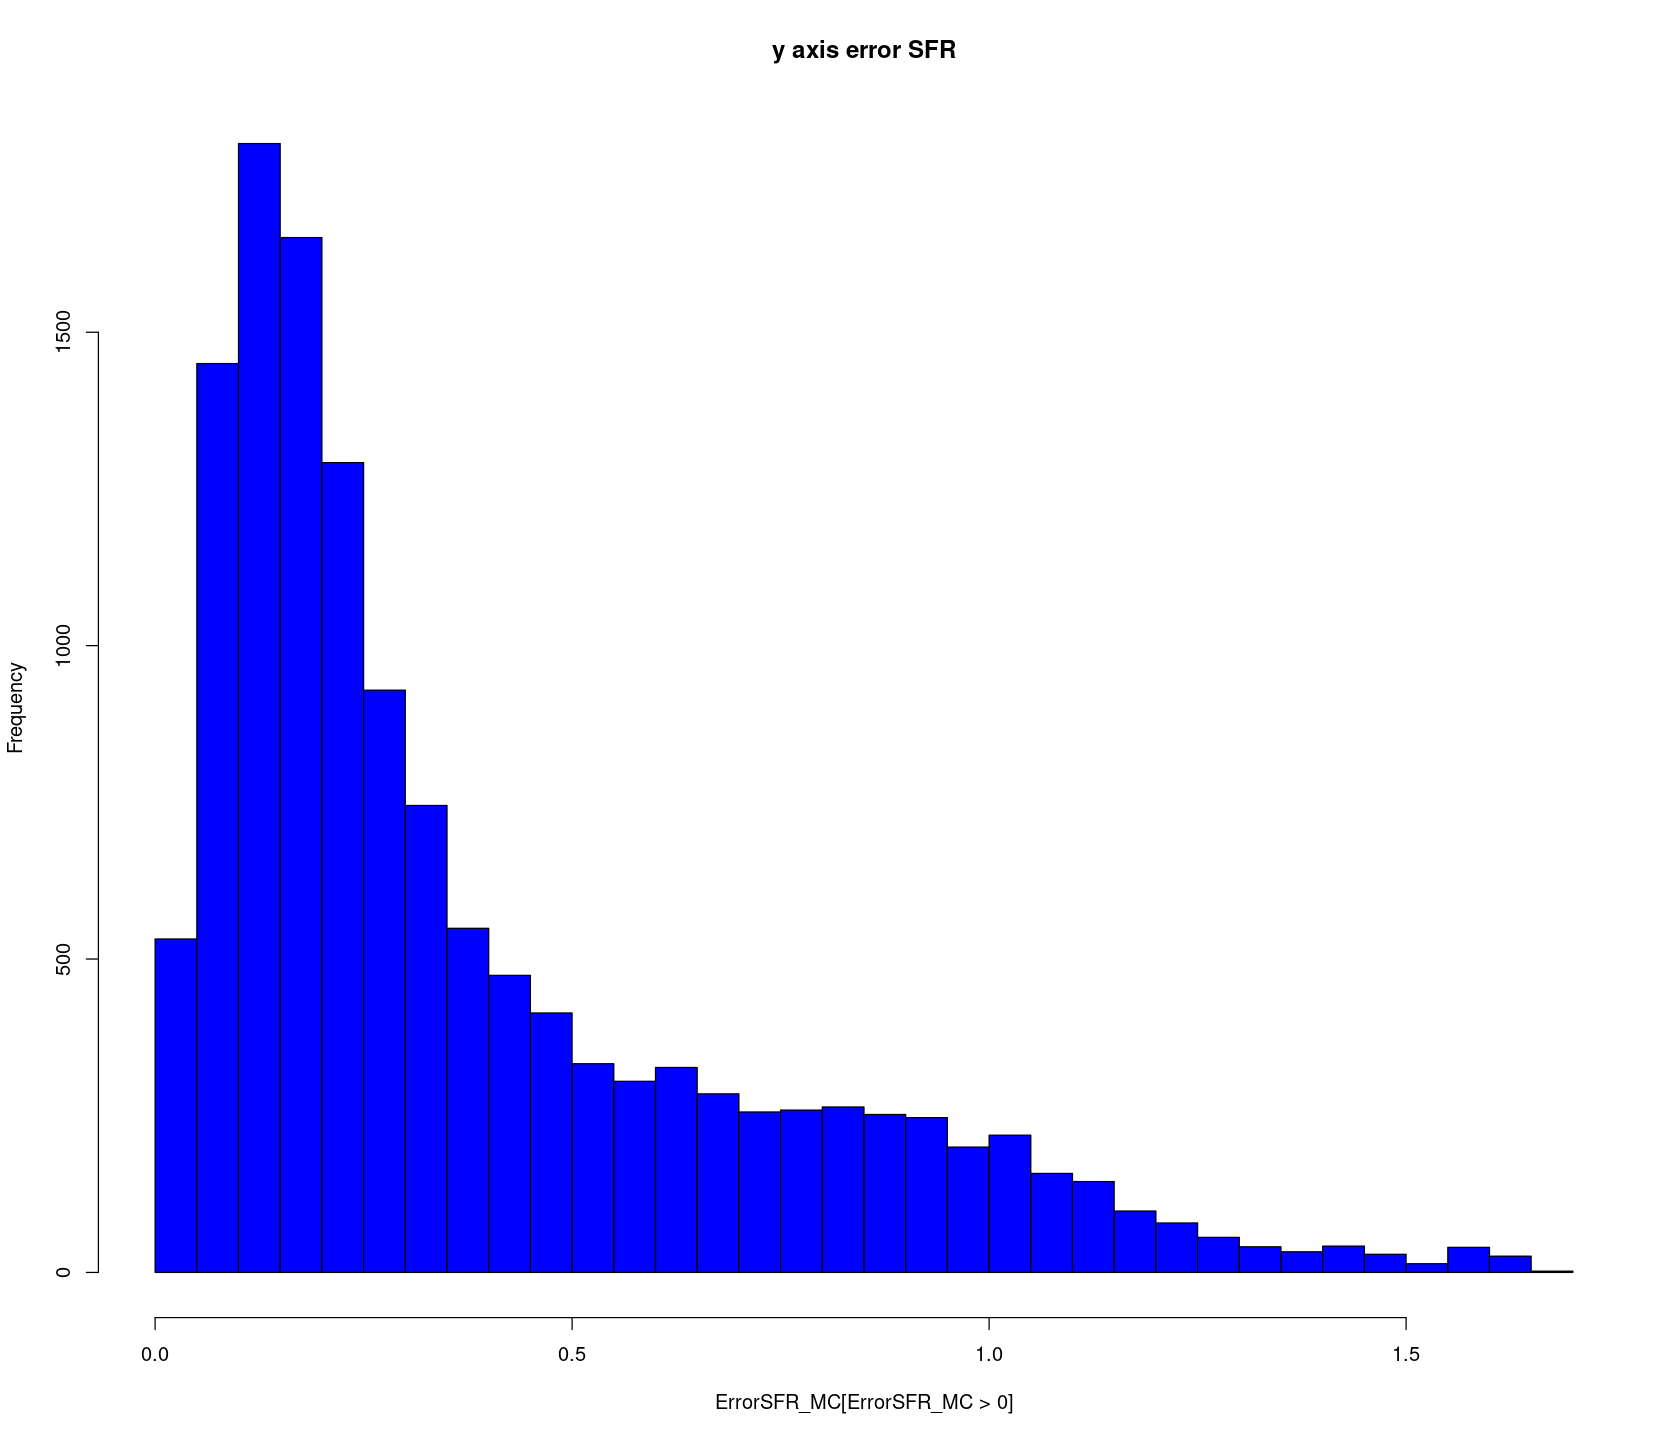

In [6]:
#ERROR PROPAGATE MONTE-CARLO: EJE X SFRs=0.0252189442516711

ErrorSFR_MC=vector("numeric")

EXPR1=expression(log10(((EW_Ha_SF+0) * 10**(-0.4*(M_r_petro_SF-34.10))*(3*10**(18))/(6564.61*(1+z_SF))**2*((Ha_SF/Hb_SF)/2.86)**2.36)/(1.27*10**34)))

for (i in 1:length(data_SF$Ha)){ # length(data_SF$Ha)

    Ha_SF=c(data_SF2$Ha_obs_SF[i],data_SF2$Ha_obs_SF_Error[i])
    Hb_SF=c(data_SF2$Hb_obs_SF[i],data_SF2$Hb_obs_SF_Error[i])
    
    EW_Ha_SF=c(data_SF2$EW_Ha_SF[i],0) # omiting error: data_SF2$EW_Ha_SF_Error[i]
    M_r_petro_SF=c(data_SF$M_r_petro[i],0)
    z_SF=c(data_SF$z[i],0)

    DF1=makeDat(EXPR1)
 
    RES2=propagate(expr=EXPR1,data=DF1,type="stat",second.order=FALSE,nsim=10000,do.sim=TRUE)
    ErrorSFR_MC[i]=ifelse(RES2$sim[2]>0,RES2$sim[2],-9999.0)

    #progress_bar(i,length(data_SF$Ha)) # length(data_SF$Ha)
    #Sys.sleep(0.1)
}

hist(ErrorSFR_MC[ErrorSFR_MC>0],breaks='fd',col="blue",main = "y axis error SFR")
median(ErrorSFR_MC[ErrorSFR_MC>0], na.rm = TRUE)

## 6. Data B: Fils, Tendrils and Voids



In [7]:
#GALAXIAS FILS
data_Fils=read.table("./DataFrames_and_Tables/data_frame_Fils.txt") #datos
names(data_Fils)=c("Ha","Ha_Error","Hb","Hb_Error","NII","NII_Error","OIII","OIII_Error","EW_Ha","M_r_petro","z") #nombres datos bpt diagram

Ha_SF_Fils=data_Fils$Ha #Ha_SF
Ha_SF_Error_Fils=data_Fils$Ha_Error #error Ha_SF

Hb_SF_Fils=data_Fils$Hb #Hb_SF
Hb_SF_Error_Fils=data_Fils$Hb_Error #error Hb_SF

NII_SF_Fils=data_Fils$NII #NII_SF
NII_SF_Error_Fils=data_Fils$NII_Error #error NII_SF

OIII_SF_Fils=data_Fils$OIII #OIII_SF
OIII_SF_Error_Fils=data_Fils$OIII_Error #error OIII_SF

EW_Ha_SF_Fils=data_Fils$EW_Ha #EW_SF

M_r_petro_SF_Fils=data_Fils$M_r_petro #magnitud_r_petrosian_SF
z_SF_Fils=data_Fils$z #rdshift_SF

data_Fils[0:5,0:11]
length(Ha_SF_Fils) #longitud de las galaxias SF

,Ha,Ha_Error,Hb,Hb_Error,NII,NII_Error,OIII,OIII_Error,EW_Ha,M_r_petro,z
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,918.1491,91.864128,320.68293,38.23389,245.92322,26.895393,195.99964,27.177841,53.20128,-18.48071,0.196488
2,211.6135,28.945866,84.99964,36.69710,81.53038,18.020811,57.56998,29.229662,24.76499,-20.72695,0.186815
3,438.6802,50.915630,153.18088,26.27952,131.85155,18.416273,73.62870,15.544444,36.69381,-20.56854,0.208173
4,127.1932,8.698966,84.80415,13.27375,31.38522,7.432337,110.40400,9.586959,11.44074,-20.55494,0.206995
5,6520.4427,185.334625,2274.89555,69.19073,2090.16468,53.508343,1456.30688,43.091530,117.02758,-20.64930,0.188566


[1] 258

In [8]:
#GALAXIAS TENDRILS
data_Tendril=read.table("./DataFrames_and_Tables/data_frame_Tendril.txt") #datos
names(data_Tendril)=c("Ha","Ha_Error","Hb","Hb_Error","NII","NII_Error","OIII","OIII_Error","EW_Ha","M_r_petro","z") #nombres datos bpt diagram

Ha_SF_Tendril=data_Tendril$Ha #Ha_SF
Ha_SF_Error_Tendril=data_Tendril$Ha_Error #error Ha_SF

Hb_SF_Tendril=data_Tendril$Hb #Hb_SF
Hb_SF_Error_Tendril=data_Tendril$Hb_Error #error Hb_SF

NII_SF_Tendril=data_Tendril$NII #NII_SF
NII_SF_Error_Tendril=data_Tendril$NII_Error #error NII_SF

OIII_SF_Tendril=data_Tendril$OIII #OIII_SF
OIII_SF_Error_Tendril=data_Tendril$OIII_Error #error OIII_SF

EW_Ha_SF_Tendril=data_Tendril$EW_Ha #EW_SF

M_r_petro_SF_Tendril=data_Tendril$M_r_petro #magnitud_r_petrosian_SF
z_SF_Tendril=data_Tendril$z #rdshift_SF

data_Tendril[0:5,0:11]
length(Ha_SF_Tendril) #longitud de las galaxias SF

,Ha,Ha_Error,Hb,Hb_Error,NII,NII_Error,OIII,OIII_Error,EW_Ha,M_r_petro,z
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,368.7669,13.63515,67.38100,15.185270,56.46208,23.833967,345.04029,15.796330,92.76756,-20.56854,0.194818
2,519.9517,11.60386,229.61920,14.457220,95.25224,9.480859,257.99459,13.578528,30.81700,-20.64930,0.179598
3,282.1876,20.90209,68.04723,13.186610,53.05212,9.839131,56.88307,9.672944,36.10687,-20.58587,0.194144
4,798.7667,15.76202,76.18990,6.995211,341.41348,8.238942,100.40946,7.354587,21.06113,-21.23829,0.182238
5,188.3324,20.22932,316.47510,13.970790,52.44095,11.536447,32.20980,7.304430,26.08047,-20.68914,0.204408


[1] 1498

In [9]:
#GALAXIAS VOID
data_Voids=read.table("./DataFrames_and_Tables/data_frame_Void.txt") #datos
names(data_Voids)=c("Ha","Ha_Error","Hb","Hb_Error","NII","NII_Error","OIII","OIII_Error","EW_Ha","M_r_petro","z") #nombres datos bpt diagram

Ha_SF_Void=data_Voids$Ha #Ha_SF
Ha_SF_Error_Void=data_Voids$Ha_Error #error Ha_SF

Hb_SF_Void=data_Voids$Hb #Hb_SF
Hb_SF_Error_Void=data_Voids$Hb_Error #error Hb_SF

NII_SF_Void=data_Voids$NII #NII_SF
NII_SF_Error_Void=data_Voids$NII_Error #error NII_SF

OIII_SF_Void=data_Voids$OIII #OIII_SF
OIII_SF_Error_Void=data_Voids$OIII_Error #error OIII_SF

EW_Ha_SF_Void=data_Voids$EW_Ha #EW_SF

M_r_petro_SF_Void=data_Voids$M_r_petro #magnitud_r_petrosian_SF
z_SF_Void=data_Voids$z #rdshift_SF

data_Voids[0:5,0:11]
length(Ha_SF_Void) #longitud de las galaxias SF

,Ha,Ha_Error,Hb,Hb_Error,NII,NII_Error,OIII,OIII_Error,EW_Ha,M_r_petro,z
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,192.8170,4.617549,67.38100,5.955303,69.34403,3.990823,26.35820,3.574476,43.14306,-20.64796,0.212288
2,657.2317,51.109428,229.61920,25.781360,215.04665,20.439186,137.97212,22.680035,48.77786,-20.98282,0.170667
3,194.6713,23.538254,68.04723,16.600480,73.82740,9.939935,39.33358,13.917353,29.48997,-20.53198,0.168785
4,189.1108,7.730678,76.18990,11.990180,52.74416,5.516213,69.41970,10.539199,45.33809,-21.03748,0.197891
5,802.7272,11.935896,316.47510,18.764680,153.13379,9.072346,719.80633,28.675425,83.63927,-20.59800,0.127225


[1] 192

## 7. Errors Metallicities: Fils, Tendrils and Voids

Nótese que estamos trabajando con galaxias SF, pues estas las subdividimos en Fils, Tendrils y Voids

### Fils

#### x axis error of Fils

In [10]:
#ERROR PROPAGATE MONTE-CARLO: EJE X METALICIDADES=median(dellogmstar_SF)
0.11796202

[1] 0.117962

#### y axis error of Fils

In [ ]:
#ERROR PROPAGATE MONTE-CARLO: EJE Y METALICIDADES=0.0175045433154089

ErrorMet_MC=vector("numeric")

EXPR1=expression(8.73-0.32*log10((OIII_SF_Fils/Hb_SF_Fils)/(NII_SF_Fils/Ha_SF_Fils)))

for (i in 1:100){ #length(data_Fils$Ha)

    Ha_SF_Fils=c(data_Fils$Ha[i],data_Fils$Ha_Error[i])
    Hb_SF_Fils=c(data_Fils$Hb[i],data_Fils$Hb_Error[i])
    OIII_SF_Fils=c(data_Fils$OIII[i],data_Fils$OIII_Error[i])
    NII_SF_Fils=c(data_Fils$NII[i],data_Fils$NII_Error[i])

    DF1=makeDat(EXPR1)
 
    RES2=propagate(expr=EXPR1,data=DF1,type="stat",second.order=FALSE,nsim=10000,do.sim=TRUE)
    ErrorMet_MC[i]=ifelse(RES2$sim[2]>0,RES2$sim[2],-9999.0)

    #progress_bar(i,100)
    #Sys.sleep(0.1)
}

hist(ErrorMet_MC[ErrorMet_MC>0],xlim=c(0,0.25),breaks='fd',col="blue",main = "y axis error of Fils")

median(ErrorMet_MC[ErrorMet_MC>0])

### Tendrils

#### x axis error of Tendrils

In [11]:
#ERROR PROPAGATE MONTE-CARLO: EJE X METALICIDADES=median(dellogmstar_SF)
0.119726494

[1] 0.1197265

#### y axis error of Tendrils

In [ ]:
#ERROR PROPAGATE MONTE-CARLO: EJE Y METALICIDADES=0.0232942981804439

ErrorMet_MC=vector("numeric")

EXPR1=expression(8.73-0.32*log10((OIII_SF_Tendril/Hb_SF_Tendril)/(NII_SF_Tendril/Ha_SF_Tendril)))

for (i in 1:100){ #length(data_Tendril$Ha)

    Ha_SF_Tendril=c(data_Tendril$Ha[i],data_Tendril$Ha_Error[i])
    Hb_SF_Tendril=c(data_Tendril$Hb[i],data_Tendril$Hb_Error[i])
    OIII_SF_Tendril=c(data_Tendril$OIII[i],data_Tendril$OIII_Error[i])
    NII_SF_Tendril=c(data_Tendril$NII[i],data_Tendril$NII_Error[i])

    DF1=makeDat(EXPR1)
 
    RES2=propagate(expr=EXPR1,data=DF1,type="stat",second.order=FALSE,nsim=10000,do.sim=TRUE)
    ErrorMet_MC[i]=ifelse(RES2$sim[2]>0,RES2$sim[2],-9999.0)

    #progress_bar(i,100)
    #ys.sleep(0.1)
}

hist(ErrorMet_MC[ErrorMet_MC>0],xlim=c(0,0.25),breaks='fd',col="blue",main = "y axis error of Tendrils")

median(ErrorMet_MC[ErrorMet_MC>0])

### Voids

#### x axis error of Void

In [12]:
#ERROR PROPAGATE MONTE-CARLO: EJE X METALICIDADES=median(dellogmstar_SF)
0.11887183

[1] 0.1188718

#### y axis error of Voids

In [ ]:
#ERROR PROPAGATE MONTE-CARLO: EJE Y METALICIDADES=0.0248389164321768

ErrorMet_MC=vector("numeric")

EXPR1=expression(8.73-0.32*log10((OIII_SF_Void/Hb_SF_Void)/(NII_SF_Void/Ha_SF_Void)))

for (i in 1:100){ #length(data_Voids$Ha)

    Ha_SF_Void=c(data_Voids$Ha[i],data_Voids$Ha_Error[i])
    Hb_SF_Void=c(data_Voids$Hb[i],data_Voids$Hb_Error[i])
    OIII_SF_Void=c(data_Voids$OIII[i],data_Voids$OIII_Error[i])
    NII_SF_Void=c(data_Voids$NII[i],data_Voids$NII_Error[i])

    DF1=makeDat(EXPR1)
 
    RES2=propagate(expr=EXPR1,data=DF1,type="stat",second.order=FALSE,nsim=10000,do.sim=TRUE)
    ErrorMet_MC[i]=ifelse(RES2$sim[2]>0,RES2$sim[2],-9999.0)

    #progress_bar(i,100)
    #Sys.sleep(0.1)
}

hist(ErrorMet_MC[ErrorMet_MC>0],xlim=c(0,0.25),breaks='fd',col="blue",main = "y axis error of Voids")

median(ErrorMet_MC[ErrorMet_MC>0])